In [26]:
pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.2/155.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 8.4 MB/s eta 0:00:00m eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.2 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


     mois                      region  nombre_total_passages  \
0    12.0     Bourgogne-Franche-Comté                  29498   
1     9.0                   Occitanie                 262879   
2     6.0                   Normandie                 195587   
3     5.0                     Mayotte                   7662   
4     3.0                   Normandie                 192348   
..    ...                         ...                    ...   
187   8.0                  La Réunion                  29380   
188   1.0            Pays de la Loire                 102730   
189  10.0  Provence-Alpes-Côte d'Azur                 202151   
190   4.0          Nouvelle-Aquitaine                 217383   
191   9.0                    Bretagne                 141016   

     nombre_passage_corona             pourcentage  
0                      424      1.4373855854634212  
1                     2920      1.1107772016783387  
2                      244  0.12475266761083303083  
3                  

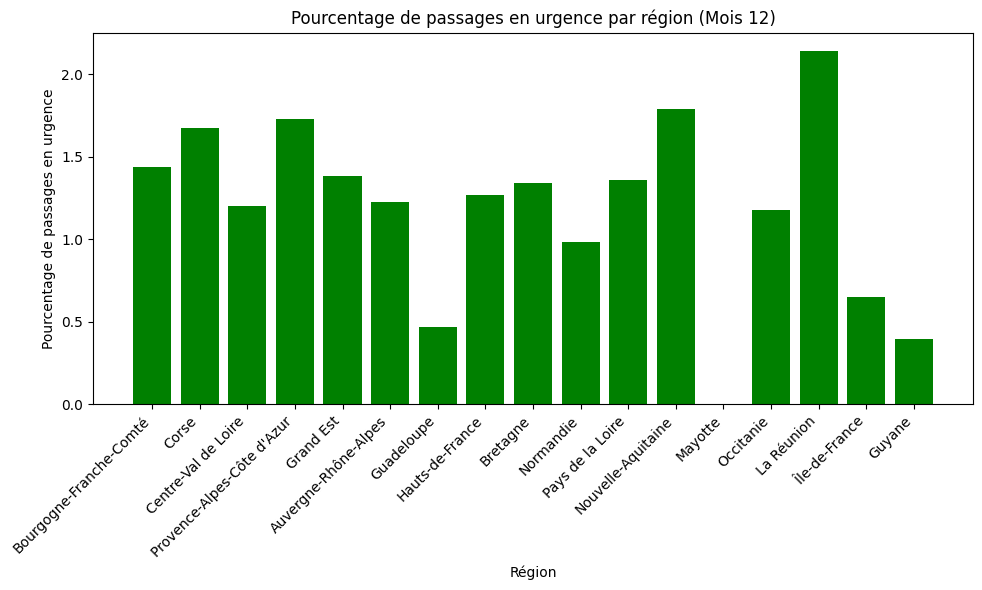

In [4]:
import psycopg2
import numpy as np 
import psycopg2.extras as extras 
import pandas as pd 
import matplotlib.pyplot as plt
def connexion():
    return psycopg2.connect(
   database="postgres",
   user="airflow",
   password="airflow",
   host="172.17.0.1",
   port= '5435')

def lecture(conn):
    """ Lecture des tables """
    command = """
        SELECT
            EXTRACT(MONTH FROM um.date_de_passage) AS mois,
            d.region,
            SUM(nbre_pass_tot) AS nombre_total_passages,
            SUM(nbre_pass_corona) AS nombre_passage_corona,
            (SUM(nbre_pass_corona)*100.0)/SUM(nbre_pass_tot) AS pourcentage
            
        FROM
            urgence_mesures um
        JOIN
            departement d ON um.dep = d.id_dep
        GROUP BY
            mois,d.region;
        """
    try:
        cur = conn.cursor()
        cur.execute(command)
        
        # Fetch data
        data = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        df = pd.DataFrame(data, columns=columns)
        
        # Display the DataFrame
        print(df)

    except (Exception, psycopg2.DatabaseError) as error:
        print("Error")
        print(error)
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
        return df

# Call the function
connexion_instance = connexion()
df = lecture(connexion_instance)

# Filtrer les données pour un mois spécifique (par exemple, le mois 12)
df_mois_12 = df[df['mois'] == 12.0]

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(df_mois_12['region'], df_mois_12['pourcentage'], color='green')
plt.xlabel('Région')
plt.ylabel('Pourcentage de passages en urgence')
plt.title('Pourcentage de passages en urgence par région (Mois 12)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher le graphique
plt.show()